 # Sprint 深層学習スクラッチ ニューラルネットワーク

In [374]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import tensorflow as tf
import time

## MNISTデータセット

In [375]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [378]:
# サンプル数は60000，1個のサンプルが28×28個の特徴量を持っている
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#1個の特徴量は0～255の値が入っている
print('unique:\n',np.unique(X_train))

(60000, 28, 28)
(10000, 28, 28)
uint8
unique:
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234

## 平滑化
* (1, 28, 28)の各画像を、(1, 784)に変換
* 機械学習手法や、今回扱う全結合層のみのニューラルネットワークではこの形で扱う
* 全てのピクセルが一列になっていることを、 平滑化（flatten） してあるという風に表現する                                
**《補足》**                    
* ここまで機械学習を学んでくる中で、特徴量の数を「次元」と呼んできた。その視点ではMNISTは784次元のデータ
* 一方で、NumPyのshapeが(784,)の状態を1次元配列とも呼ぶ。
* 画像としての縦横の情報を持つ（28, 28)の状態であれば、2次元配列。この視点では2次元のデータ
* さらに、もしもカラー画像であれば(28, 28, 3)ということになり、3次元配列＝3次元データ
* 白黒でもカラーでも平面画像であり、立体データではないという視点で、2次元のデータ
* 画像データを扱う際にはこのように「次元」という言葉が複数の意味合いで使われることに注意してください。

In [379]:
# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

## 画像データの可視化

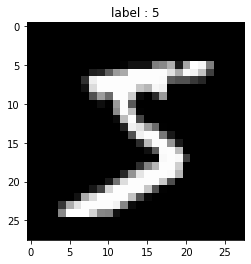

In [380]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

### 《発展的話題》
* 画像データは符号なし8ビット整数のuint8型で保持されることが一般的だが、plt.imshowはより自由な配列を画像として表示することが可能
* 例えば、以下のようにマイナスの値を持ったfloat64型の浮動小数点であってもエラーにはならないし、先ほどと全く同じ風に表示される

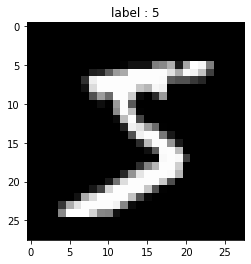

In [382]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
#print(image) # 値を確認

* これは、自動的に値を0〜255の整数に変換して処理するように作られているから
* uint8型であっても最小値が0、最大値が255でない場合には色合いがおかしくなる
* それを防ぐためには次のように引数を入れる

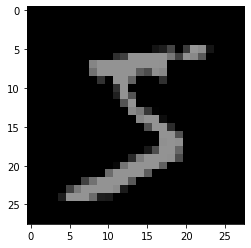

In [383]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

画像関係のライブラリではこの自動的なスケーリングが思わぬ結果を生むことがあるので、新しいメソッドを使うときには確認しておく

# 前処理
### １．型の変換
画像は0から255のuint8型で表されるが、機械学習をする上では0から1のfloat型で扱うことになる．以下のコードで変更可

In [384]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0
print('X_train_shape',X_train.shape)

1.0
0.0
X_train_shape (60000, 784)


### ２．one-hot表現
* 正解ラベルは0から9の整数だが、ニューラルネットワークで多クラス分類を行う際にはone-hot表現に変換する
* scikit-learnのOneHotEncoderを使用したコードが以下．このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱う

In [385]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print('y_train_shape',y_train.shape) # (60000,)
print('y_train_one_hot_shape',y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

y_train_shape (60000,)
y_train_one_hot_shape (60000, 10)
float64


### ３．trainデータをtrainとバリデーションに分ける

In [386]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape)

(48000, 784)
(12000, 784)
(48000,)


In [387]:
# 分けたデータのｙOne-Hot表現に
y_val_one = enc.fit_transform(y_val[:, np.newaxis])
print(y_val_one_hot.shape)
y_train_one = enc.fit_transform(y_train[:, np.newaxis])
print(y_train_one.shape)

(9600, 10)
(48000, 10)


# ミニバッチ処理
* これまでの機械学習スクラッチでは、全てのサンプルを一度に計算していたが，ニューラルネットワークではデータを分割して入力する**確率的勾配降下法**が一般的
* 分割した際のひとかたまりを**ミニバッ**，そのサンプル数を**バッチサイズ**と呼ぶ
* 今回はバッチサイズを20とする．今回使う訓練用データは48000枚なので、48000÷20で2400回の更新を繰り返すことになる
* ニューラルネットワークではこれを2400回イテレーション（iteration） すると呼ぶ
* 訓練用データを一度全て見ると1回の エポック（epoch） が終わったことになる．このエポックを複数回繰り返し、学習が完了

In [388]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [389]:
# 初期化
get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=20)
print('ミニバッチの数：',len(get_mini_batch)) # 2400
#print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

ミニバッチの数： 2400


# 【問題1】重みの初期値を決めるコードの作成
* ニューラルネットワークの各層の重みの初期値を決めるコードを作成
* 重みの初期値は様々な方法が提案されているが、今回はガウス分布による単純な初期化を行う．バイアスに関しても同様
* 標準偏差の値sigmaはハイパーパラメータ．発展的な重みの初期化方法については次のSprintで扱う

In [390]:
# 特徴量数
n_features = 784
# ノード数
n_nodes1 = 400  # 1層目
n_nodes2 = 200  # 2層目
n_output = 10   # 最後のノードは出力のクラス数
batch_size = 20

# 仮データ作成
X_batch = np.array([np.random.randint(0,256) for _ in range(batch_size*n_features)])
X_batch = X_batch.reshape(batch_size,n_features)
print('仮バッチX：',X_batch.shape)
# 取り出したいndarryの全行を指定してそこから取り出したい個数を指定すれば前列をランダムに取ってくる
y_batch = y_train_one_hot[np.random.choice(y_train_one_hot.shape[0],batch_size)]
print('仮バッチy：',y_batch.shape)

仮バッチX： (20, 784)
仮バッチy： (20, 10)


In [391]:
def _wheight_fanc(n,m):
    sigma = 0.01  # ガウス分布の標準偏差
    w = sigma * np.random.randn(n,m)
    return w    

In [392]:
W1 = _wheight_fanc(n_features, n_nodes1)
W2 = _wheight_fanc(n_nodes1, n_nodes2)
W3 = _wheight_fanc(n_nodes2, n_output)
print(W1.shape)
print(W2.shape)
print(W3.shape)

(784, 400)
(400, 200)
(200, 10)


# 【問題2】フォワードプロパゲーションの実装
入力層を出発点として，トレーニングデータのパターンを順方向に伝播させ，モデルの出力を生成する．
* 三層のニューラルネットワークのフォワードプロパゲーションを作成
* 以下ではノード数は1層目は400、2層目は200としますが、変更可
* batch_size = 20 # バッチサイズ
* n_features = 784 # 特徴量の数
* n_nodes1 = 400 # 1層目のノード数
* n_nodes2 = 200 # 2層目のノード数
* n_outn_nodes1put = 10 # 出力のクラス数（3層目のノード数）

In [393]:
# バイアスの初期化
b1 = np.zeros(n_nodes1)
b2 = np.zeros(n_nodes2)
b3 = np.zeros(n_output)

# バッチサイズ
batch_size = 20

## 活性化関数
#### １．シグモイド関数

In [394]:
# シグモイド
def _sigmoid(A):
    return 1/(1+np.exp(-A))

#### ２．ハイパボリックタンジェント関数

In [395]:
# ハイパボリックタンジェント関数
def _hyperbolic_tan(A):
    return np.tanh(A)

#### ３．ソフトマックス関数
* ソフトマックス関数を作成し、フォワードプロパゲーションの中で使用する．
* 活性化関数の一種だが，多クラス分類の出力層で使われる特性上、区別して扱われることが多い
* 分母は全てのクラスに相当する値を指数関数に通した上で足し合わせたもの
* その中で、分子にk番目のクラスを持ってくることで、k番目のクラスである確率が求まる
* これを10クラス分計算し、合わせたものがZ3
* Z3：出力 (batch_size, n_output) 　各ラベル（0〜9）に対する確率の配列

In [396]:
# softmax関数
def _softmax(A3):
    """
    Parameters
    ----------
    A3 : 次の形のndarray, shape (n_batch_size, 10)
    　　 ニューラルネットワークの出力
    Returns
    -------
    次の形のndarray, shape (n_batch_size, )
    各ラベルに属する確率
    """
    exp_A = np.exp(A3)
    sum_A = np.sum(exp_A)
    return exp_A/sum_A

In [397]:
# フォーワードプロパゲーション
def _forward(X,W1,W2,W3,b1,b2,b3):
    """
    Parameters
    ----------
    X : 特徴量ベクトル ndarray, shape (n_batch_size,n_features)
    W1 :
    Returns
    -------
    A1,Z1,A2,Z2,A3,Z3
    次の形のndarray, shape (n_batch_size, )
    各ラベルに属する確率
    """
    f = _hyperbolic_tan
    A1 = np.dot(X,W1)+b1  #shape(batch_size, n_nodes1)
    Z1 = f(A1)      #shape(batch_size, n_nodes1)
    
    A2 = np.dot(Z1,W2)+b2  #shape(batch_size, n_nodes2)
    Z2 = f(A2)       #shape(batch_size, n_nodes2)
    
    A3 = np.dot(Z2,W3)+b3  #shape(batch_size, n_output)
    Z3 = _softmax(A3)       #shape(batch_size, n_output)
    return A1,Z1,A2,Z2,A3,Z3

In [398]:
# 仮データで確認
A1,Z1,A2,Z2,A3,Z3=_forward(X_batch,W1,W2,W3,b1,b2,b3)
print('A1',A1.shape)
print(A1[0:1,0:2],'\n')
print('Z1',Z1.shape)
print(Z1[0:1,0:2],'\n')
print('A2',A2.shape)
print(A2[0:1,0:2],'\n')
print('Z2',Z2.shape)
print(Z2[0:1,0:2],'\n')
print('A3',A3.shape)
print(A3[0:1,0:2],'\n')
print('Z3',Z3.shape)
print(Z3[0:1,0:2],'\n')

A1 (20, 400)
[[ -2.76491735 -28.77385427]] 

Z1 (20, 400)
[[-0.99209805 -1.        ]] 

A2 (20, 200)
[[ 0.14910351 -0.13013679]] 

Z2 (20, 200)
[[ 0.1480083  -0.12940709]] 

A3 (20, 10)
[[-0.0147114  -0.02491768]] 

Z3 (20, 10)
[[0.00495018 0.00489992]] 



# 【問題3】交差エントロピー誤差の実装
サンプル1つあたりの誤差が求まります。      
メモ：０を対数変換できないので，あらかじめものすごい小さい値を足しておくといいらしい．

In [399]:
def cross_entropy(y,Z3):
    """
    Parameters
    ----------
    Z3 : 次の形のndarray, shape (n_batch_size, 10)
    　　 ニューラルネットワークの出力
    y : 次の形のndarray, shape (n_batch_size,10)
    one-Hot表現にした正解値
    Returns
    -------
    scaler
    交差エントロピー誤差
    """
    # １次元のものが入ってきたら，形をそろえる
    if Z3.ndim == 1:
        y = y.reshape(1,y.size)
        Z3 = Z3.reshape(1,Z3.size)
    n_b = Z3.shape[0]
    # アダマール積の総和÷バッチサイズ
    loss = -np.sum(y*np.log(Z3+1e-7))/n_b
    return loss

In [400]:
loss=cross_entropy(y_batch,Z3)
print(loss)

5.2972845425030455


# 【問題4】バックプロパゲーションの実装
* 三層のニューラルネットワークのバックプロパゲーションを作成
* 確率的勾配降下法で，重みとバイアスを更新するフェーズ
* ＝W１～３とB１～３を更新したものを求める
* 各層の重みの shapeの考え方「前の層のノード数と現在のノード数」
* 各層のバイアスのshapeの考え方「バイアスはベクトルで，Aの損失の平均」
* メモ：{}の中はスカラーではなく，ベクトル（式のまま）　L_Z2とかけるのがアダマール積「×」マークはアダマール，「・」はドット積

In [403]:
# 学習率
alpha = 0.0001

def back_propagation(batch_size,y,Z3,Z2,Z1,W3,W2,W1):
    n_b = batch_size
    ### 3層目 ###
    print('node3')
    L_A3 = (np.sum(Z3-y_batch,axis=0)/n_b).reshape(1,10)  #shape(1,10)
    print('L_A3',L_A3.shape)
    L_b3 = L_A3  #shape(1,10)
    L_W3 = (np.sum(Z2.T,axis=1)/n_b).reshape(-1,1)*L_A3  #shape(n_node2,10)
    print('L_W3',L_W3.shape)
    L_Z2 = (L_A3@W3.T).T  #shape(n_node2,1)
    print('L_Z2',L_Z2.shape)
    # 重みの更新
    new_W3 = W3 - alpha*L_W3
    print('new_W3',new_W3.shape)
    # バイアスの更新
    new_b3 = b3 - alpha*L_b3
    print('new_b3',new_b3.shape,'\n')

    
    ### 2層目 ###
    print('node2')
    step1 = 1-(np.tanh(np.sum(A2,axis=0)/n_b)**2).reshape(-1,1)
    print('{}の中のshape',step1.shape)
    L_A2 = (L_Z2*step1).reshape(1,-1)
    print('L_A2',L_A2.shape) #shape(1, n_nodes2)
    L_b2 = L_A2
    L_W2 = ((np.sum(Z1.T,axis=1)/n_b).reshape(-1,1))@L_A2
    print('L_W2',L_W2.shape)#shape (n_nodes1, n_nodes2)
    L_Z1 = (L_A2@W2.T).reshape(-1,1)
    print('L_Z1',L_Z1.shape)#shape (n_nodes1, 1)
    # 重みの更新
    new_W2 = W2 - alpha*L_W2
    print('new_W2',new_W2.shape)
    # バイアスの更新
    new_b2 = b2 - alpha*L_b2
    print('new_b2',new_b2.shape,'\n')


    ###１層目####
    print('node1')
    L_A1 = (L_Z1 * (1 - np.tanh(np.sum(A2)/n_b)**2)).reshape(1,-1)
    print('L_A1',L_A1.shape)
    L_b1 = L_A1
    L_W1 = (np.sum(X_batch.T,axis=1)/n_b).reshape(-1,1)@L_A1
    print('L_W1',L_W1.shape)
    # 重みの更新
    new_W1 = W1 - alpha*L_W1
    print('new_W1',new_W1.shape)
    # バイアスの更新
    new_b1 = b1 - alpha*L_b1
    print('new_b1',new_b1.shape)
    
    return new_W3,new_W2,new_W1,new_b3,new_b2,new_b1

In [404]:
new_W3,new_W2,new_W1,new_b3,new_b2,new_b1 = back_propagation(batch_size,y_batch,Z3,Z2,Z1,W3,W2,W1)

node3
L_A3 (1, 10)
L_W3 (200, 10)
L_Z2 (200, 1)
new_W3 (200, 10)
new_b3 (1, 10) 

node2
{}の中のshape (200, 1)
L_A2 (1, 200)
L_W2 (400, 200)
L_Z1 (400, 1)
new_W2 (400, 200)
new_b2 (1, 200) 

node1
L_A1 (1, 400)
L_W1 (784, 400)
new_W1 (784, 400)
new_b1 (1, 400)


### 平均をとらずにバイアスを求める

In [405]:
### 3層目 ###
print('node3')
L_A3 = Z3-y_batch  #shape(20,10)
print('L_A3',L_A3.shape)
L_b3 = np.sum(L_A3,axis=0)  #shape(10,)
print('L_b3',L_b3.shape)
L_W3 = Z2.T@L_A3  #shape(200,10)
print('L_W3',L_W3.shape)
L_Z2 = L_A3@W3.T  #shape(20,200)
print('L_Z2',L_Z2.shape)
# 重みの更新
new_W3 = W3 - alpha*L_W3
print('new_W3',new_W3.shape)
# バイアスの更新
new_b3 = b3 - alpha*L_b3
print('new_b3',new_b3.shape,'\n')

### 2層目 ###
print('node2')
step1 = 1-(np.tanh(A2)**2)
print('{}の中のshape',step1.shape)
L_A2 = L_Z2*step1
print('L_A2',L_A2.shape) #shape(1, n_nodes2)
L_b2 = np.sum(L_A2,axis=0)
print('L_b2',L_b2.shape)
L_W2 = Z1.T@L_A2
print('L_W2',L_W2.shape)#shape (n_nodes1, n_nodes2)
L_Z1 = L_A2@W2.T
print('L_Z1',L_Z1.shape)#shape (n_nodes1, 1)
# 重みの更新
new_W2 = W2 - alpha*L_W2
print('new_W2',new_W2.shape)
# バイアスの更新
new_b2 = b2 - alpha*L_b2
print('new_b2',new_b2.shape,'\n')


###１層目####
print('node1')
L_A1 = L_Z1 * (1 - np.tanh(A1)**2)
print('L_A1',L_A1.shape)
L_b1 = np.sum(L_A1,axis=0)
print('L_b1',L_b1.shape)
L_W1 = X_batch.T@L_A1
print('L_W1',L_W1.shape)
# 重みの更新
new_W1 = W1 - alpha*L_W1
print('new_W1',new_W1.shape)
# バイアスの更新
new_b1 = b1 - alpha*L_b1
print('new_b1',new_b1.shape)

node3
L_A3 (20, 10)
L_b3 (10,)
L_W3 (200, 10)
L_Z2 (20, 200)
new_W3 (200, 10)
new_b3 (10,) 

node2
{}の中のshape (20, 200)
L_A2 (20, 200)
L_b2 (200,)
L_W2 (400, 200)
L_Z1 (20, 400)
new_W2 (400, 200)
new_b2 (200,) 

node1
L_A1 (20, 400)
L_b1 (400,)
L_W1 (784, 400)
new_W1 (784, 400)
new_b1 (400,)


# 【問題５】推定
フォワードプロパゲーションによって出力された10個の確率の中で，最も高いものはどれか判定する

In [406]:
# 更新した重みを使う．
def predict(X):
    A1,Z1,A2,Z2,A3,Z3 = _forward(X,new_W1,new_W2,new_W3,new_b1,new_b2,new_b3)
    pred = np.argmax(Z3,axis=1)
    return pred

In [407]:
y_pred = predict(X_batch)
print('y_pred_shape',y_pred.shape)
y_pred

y_pred_shape (20,)


array([2, 5, 2, 3, 5, 2, 3, 2, 3, 2, 6, 3, 3, 5, 2, 6, 8, 2, 2, 5],
      dtype=int64)

# classにする

In [408]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    
    def __init__(self, verbose,n_nodes1,n_nodes2,n_output,batch_size,alpha,epoch):
        self.verbose = verbose
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.n_b = batch_size
        self.alpha = alpha
        self.epoch = epoch
        
    
    def _wheight_fanc(self,n,m):
        """
        重みの初期値を作る
        
        Parameters
        ----------
        n : 重みのshape[0]
        m : 重みのshape[1]
        
        Returns
        -------
        w : 次の形のndarray, shape (n,m)  各層の重みの初期値
        """
        sigma = 0.01  # ガウス分布の標準偏差
        w = sigma * np.random.randn(n,m)
        return w
    
    
    def _sigmoid(self,A):
        """
        シグモイド関数（活性化関数）
        
        Parameters
        ----------
        A : 次の形のndarray shape(batch_size,n_nodes)
        
        Returns
        -------
        次の形のndarray  shape (batch_size,n_nodes) 
        """
        return 1/(1 + np.exp(-A))
    
    def _hyperbolic_tan(self,A):
        """
        ハイパボリックタンジェント関数（活性化関数）
        
        Parameters
        ----------
        A : 次の形のndarray shape(batch_size,n_nodes)
        
        Returns
        -------
        次の形のndarray  shape (batch_size,n_nodes) 
        """
        return np.tanh(A)
    
    def _softmax(self,A3):
        """
        Parameters
        ----------
        A3 : 次の形のndarray, shape (n_batch_size, 10)
             ニューラルネットワークの出力
        Returns
        -------
            次の形のndarray, shape (n_batch_size, ) 各ラベルに属する確率
        """
        exp_A = np.exp(A3)
        sum_A = np.sum(exp_A,axis=1).reshape(-1,1)
        return exp_A/sum_A
    
    def _forward(self,X):
        """
        フォワードプロパゲーション
        Parameters
        ----------
        X : 特徴量ベクトル ndarray, shape (n_batch_size,n_features)
        W : 重み行列　ndarray, shape (n,m)
        b : バイアスベクトル　ndarray, shape (n_nodes,) 
        Returns
        -------
        A : 各ラベルに属する確率 ndarray, shape (n_batch_size, n_nodes)
        Z : 各ラベルのフラグ　ndarray, shape (n_batch_size, n_nodes)
        各ラベルに属する確率
        """
        # 活性化関数がハイパボリックタンジェントの場合
        A1 = np.dot(X,self.W1) + self.b1  #shape(batch_size, n_nodes1)
        Z1 = self._hyperbolic_tan(A1)      #shape(batch_size, n_nodes1)

        A2 = np.dot(Z1,self.W2) + self.b2  #shape(batch_size, n_nodes2)
        Z2 = self._hyperbolic_tan(A2)       #shape(batch_size, n_nodes2)
        
        A3 = np.dot(Z2,self.W3) + self.b3  #shape(batch_size, n_output)
        Z3 = self._softmax(A3)       #shape(batch_size, n_output)
        return A1,Z1,A2,Z2,A3,Z3
    
    
    def cross_entropy(self,y,Z3):
        """
        Parameters
        ----------
        Z3 : ニューラルネットワークの出力 ndarray, shape (n_batch_size, 10)
        y : one-Hot表現にした正解値 ndarray, shape (n_batch_size,10)
        
        Returns
        -------
        loss : 交差エントロピー誤差 scaler
        """
        # １次元のものが入ってきたら，形をそろえる
        if Z3.ndim == 1:
            y = y.reshape(1,y.size)
            Z3 = Z3.reshape(1,Z3.size)
        # アダマール積の総和÷バッチサイズ
        loss = (np.sum(y*np.log(Z3)))/-self.n_b
        return loss
    
    
    def _back_propagation(self,X,y,Z3,Z2,Z1,A2,A1):
        ### 3層目 ###
        L_A3 = (np.sum(Z3-y,axis=0)/self.n_b).reshape(1,10)  #shape(1,10)
        L_b3 = L_A3  #shape(1,10)
        L_W3 = (np.sum(Z2.T,axis=1)/self.n_b).reshape(-1,1)*L_A3  #shape(n_node2,10)
        L_Z2 = (L_A3@self.W3.T).T  #shape(n_node2,1)
        # 重みの更新
        self.W3 = self.W3 - self.alpha*L_W3
        # バイアスの更新
        self.b3 = self.b3 - self.alpha*L_b3

        ### 2層目 ###
        step1 = 1-(np.tanh(np.sum(A2,axis=0)/n_b)**2).reshape(-1,1)
        L_A2 = (L_Z2*step1).reshape(1,-1) #shape(1, n_nodes2)
        L_b2 = L_A2
        L_W2 = ((np.sum(Z1.T,axis=1)/self.n_b).reshape(-1,1))@L_A2  #shape (n_nodes1, n_nodes2)
        L_Z1 = (L_A2@W2.T).reshape(-1,1)  #shape (n_nodes1, 1)
        # 重みの更新
        self.W2 = self.W2 - self.alpha*L_W2
        # バイアスの更新
        self._b2 = self.b2 - self.alpha*L_b2
        
        ###１層目####
        L_A1 = (L_Z1 * (1 - np.tanh(np.sum(A1)/n_b)**2)).reshape(1,-1)
        L_b1 = L_A1
        L_W1 = (np.sum(X.T,axis=1)/self.n_b).reshape(-1,1)@L_A1
        # 重みの更新
        self.W1 = self.W1 - self.alpha*L_W1
        # バイアスの更新
        self.b1 = self.b1 - self.alpha*L_b1
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
            
        """
        self.n_features = X.shape[1]
        self.loss = []
        self.loss_val = []
        
        # 重み行列の初期化
        self.W1 = self._wheight_fanc(self.n_features, self.n_nodes1)
        self.W2 = self._wheight_fanc(self.n_nodes1, self.n_nodes2)
        self.W3 = self._wheight_fanc(self.n_nodes2, self.n_output)
        # バイアスベクトルの初期化
        self.b1 = np.zeros(self.n_nodes1)
        self.b2 = np.zeros(self.n_nodes2)
        self.b3 = np.zeros(self.n_output)
        
        for e in range(self.epoch):
            # ミニバッチの取得
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_b)
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワードプロパゲーションで出力を計算
                A1,Z1,A2,Z2,A3,Z3 = self._forward(mini_X_train)
                # バックプロパゲーションで重みの更新
                self._back_propagation(mini_X_train,mini_y_train,Z3,Z2,Z1,A2,A1)
            
            # 交差エントロピー誤差
            loss = self.cross_entropy(mini_y_train,Z3)
            self.loss.append(loss)

            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose is True:
                print('Train Data Loss epoch{0}: {1}'.format(e,loss))
            else:
                pass
        
        # 検証用データがある場合
        if X_val is not None:
            # 重みの初期化
            self.W1_val = self._wheight_fanc(self.n_features, self.n_nodes1)
            self.W2_val = self._wheight_fanc(self.n_nodes1, self.n_nodes2)
            self.W3_val = self._wheight_fanc(self.n_nodes2, self.n_output)
            # バイアスの初期化
            self.b1_val = np.zeros(self.n_nodes1)
            self.b2_val = np.zeros(self.n_nodes2)
            self.b3_val = np.zeros(self.n_output)
            
            for e in range(self.epoch):
                # ミニバッチの取得
                get_mini_batch_val = GetMiniBatch(X_val, y_val, batch_size=self.n_b)
                for mini_X_train_val, mini_y_train_val in get_mini_batch_val:
                    # フォワードプロパゲーションで出力を計算
                    A1_val,Z1_val,A2_val,Z2_val,A3_val,Z3_val = self._forward(mini_X_train_val)
                    # バックプロパゲーションで重みの更新
                    self._back_propagation(mini_X_train_val,mini_y_train_val,Z3_val,Z2_val,Z1_val,A2_val,A1_val)
                
                # 交差エントロピー誤差
                loss_val = self.cross_entropy(mini_y_train_val,Z3_val)
                self.loss_val.append(loss_val)
                #verboseをTrueにした際は学習過程などを出力する
                if self.verbose is True:
                    print('Test Data Loss epoch{0}: {1}'.format(e,loss_val))
                else:
                    pass
            
            
            
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)   サンプル

        Returns
        -------
        pred : 次の形のndarray, shape (n_samples, 1)  推定結果
        """
        A1,Z1,A2,Z2,A3,Z3 = self._forward(X)
        pred = np.argmax(Z3,axis=1)
        return pred

# 【問題6】学習と推定
MNISTのデータを学習・推定し、Accuracyを計算する

In [367]:
# 初期化，学習
nnc = ScratchSimpleNeuralNetrowkClassifier(verbose=True,n_nodes1=400,n_nodes2=200,n_output=10,batch_size=20,alpha=0.1,epoch=30)
nnc.fit(X_train,y_train_one,X_val,y_val_one)

Train Data Loss epoch0: 2.2737972348685105
Train Data Loss epoch1: 2.16852702472134
Train Data Loss epoch2: 1.8082976309453316
Train Data Loss epoch3: 1.2897883100011103
Train Data Loss epoch4: 0.9463505201897199
Train Data Loss epoch5: 0.7533320620300618
Train Data Loss epoch6: 0.6375636665769796
Train Data Loss epoch7: 0.5635659067017715
Train Data Loss epoch8: 0.5146202884077739
Train Data Loss epoch9: 0.4816887676119742
Train Data Loss epoch10: 0.45929197506039177
Train Data Loss epoch11: 0.4439113574386592
Train Data Loss epoch12: 0.4332425773389108
Train Data Loss epoch13: 0.42576761262834995
Train Data Loss epoch14: 0.4204817763319661
Train Data Loss epoch15: 0.4167151405316448
Train Data Loss epoch16: 0.4140159932304711
Train Data Loss epoch17: 0.41207526869603867
Train Data Loss epoch18: 0.41067784714764743
Train Data Loss epoch19: 0.4096713123342444
Train Data Loss epoch20: 0.40894591399558033
Train Data Loss epoch21: 0.40842162363233625
Train Data Loss epoch22: 0.40803963125

In [368]:
# 推定
y_pred = nnc.predict(X_test)
print('accuracy_score：',accuracy_score(y_test, y_pred))
print('y_predの中身：',np.unique(y_pred,return_counts=True))

accuracy_score： 0.8509
y_predの中身： (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([ 985, 1238,  880, 1135,  939,  908,  979,  993,  886, 1057],
      dtype=int64))


# 【問題7】学習曲線のプロット
* ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要
* trainデータとvalデータに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要がある

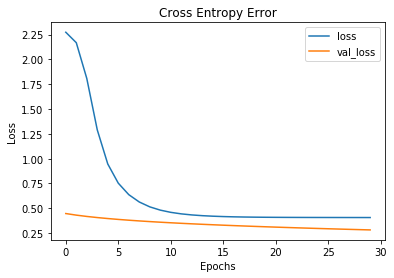

In [369]:
plt.plot(nnc.loss,label='loss')
plt.plot(nnc.loss_val,label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cross Entropy Error')
plt.legend()

# バックプロパゲーションの方法を変える（バイアスは平均をとらない）

In [409]:
class ScratchSimpleNeuralNetrowkClassifier2():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    
    def __init__(self, verbose,n_nodes1,n_nodes2,n_output,batch_size,alpha,epoch):
        self.verbose = verbose
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.n_b = batch_size
        self.alpha = alpha
        self.epoch = epoch
        
        
    
    def _wheight_fanc(self,n,m):
        """
        重みの初期値を作る
        
        Parameters
        ----------
        n : 重みのshape[0]
        m : 重みのshape[1]
        
        Returns
        -------
        w : 次の形のndarray, shape (n,m)  各層の重みの初期値
        """
        sigma = 0.01  # ガウス分布の標準偏差
        w = sigma * np.random.randn(n,m)
        return w
    
    def _sigmoid(self,A):
        """
        シグモイド関数（活性化関数）
        
        Parameters
        ----------
        A : 次の形のndarray shape(batch_size,n_nodes)
        
        Returns
        -------
        次の形のndarray  shape (batch_size,n_nodes) 
        """
        return 1/(1 + np.exp(-A))
    
    def _hyperbolic_tan(self,A):
        """
        ハイパボリックタンジェント関数（活性化関数）
        
        Parameters
        ----------
        A : 次の形のndarray shape(batch_size,n_nodes)
        
        Returns
        -------
        次の形のndarray  shape (batch_size,n_nodes) 
        """
        return np.tanh(A)
    
    def _softmax(self,A3):
        """
        Parameters
        ----------
        A3 : 次の形のndarray, shape (n_batch_size, 10)
             ニューラルネットワークの出力
        Returns
        -------
            次の形のndarray, shape (n_batch_size, ) 各ラベルに属する確率
        """
        exp_A = np.exp(A3)
        sum_A = np.sum(exp_A,axis=1).reshape(-1,1)
        return exp_A/sum_A
    
    def _forward(self,X):
        """
        フォワードプロパゲーション
        Parameters
        ----------
        X : 特徴量ベクトル ndarray, shape (n_batch_size,n_features)
        Returns
        -------
        A : 各ラベルに属する確率 ndarray, shape (n_batch_size, n_nodes)
        Z : 各ラベルのフラグ　ndarray, shape (n_batch_size, n_nodes)
        """
        # 活性化関数がハイパボリックタンジェントの場合
        A1 = np.dot(X,self.W1) + self.b1  #shape(batch_size, n_nodes1)
        Z1 = self._hyperbolic_tan(A1)      #shape(batch_size, n_nodes1)

        A2 = np.dot(Z1,self.W2) + self.b2  #shape(batch_size, n_nodes2)
        Z2 = self._hyperbolic_tan(A2)       #shape(batch_size, n_nodes2)
        
        A3 = np.dot(Z2,self.W3) + self.b3  #shape(batch_size, n_output)
        Z3 = self._softmax(A3)       #shape(batch_size, n_output)
        return A1,Z1,A2,Z2,A3,Z3
    
    def cross_entropy(self,y,Z3):
        """
        Parameters
        ----------
        Z3 : ニューラルネットワークの出力 ndarray, shape (n_batch_size, 10)
        y : one-Hot表現にした正解値 ndarray, shape (n_batch_size,10)
        
        Returns
        -------
        loss : 交差エントロピー誤差 scaler
        """
        # １次元のものが入ってきたら，形をそろえる
        if Z3.ndim == 1:
            y = y.reshape(1,y.size)
            Z3 = Z3.reshape(1,Z3.size)
        # アダマール積の総和÷バッチサイズ
        loss = (np.sum(y*np.log(Z3)))/-self.n_b
        return loss
    
    def _back_propagation(self,X,y,Z3,Z2,Z1,A2,A1):
        ### 3層目 ###
        L_A3 = Z3-y  #shape(20,10)
        L_b3 = np.sum(L_A3,axis=0)  #shape(10,)
        L_W3 = Z2.T@L_A3  #shape(200,10)
        L_Z2 = L_A3@self.W3.T  #shape(20,200)
        # 重みの更新
        self.W3 = self.W3 - self.alpha*L_W3
        # バイアスの更新
        self.b3 = self.b3 - self.alpha*L_b3

        ### 2層目 ###
        step1 = 1-(np.tanh(A2)**2)
        L_A2 = L_Z2*step1
        L_b2 = np.sum(L_A2,axis=0)
        L_W2 = Z1.T@L_A2
        L_Z1 = L_A2@self.W2.T
        # 重みの更新
        self.W2 = self.W2 - self.alpha*L_W2
        # バイアスの更新
        self.b2 = self.b2 - self.alpha*L_b2
        
        ###１層目####
        L_A1 = L_Z1 * (1 - (np.tanh(A1)**2))
        L_b1 = np.sum(L_A1,axis=0)
        L_W1 = X.T@L_A1
        # 重みの更新
        self.W1 = self.W1 - self.alpha*L_W1
        # バイアスの更新
        self.b1 = self.b1 - self.alpha*L_b1
        
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
            
        """
        self.n_features = X.shape[1]
        self.loss = []
        self.loss_val = []
        
        # 重みの初期化
        self.W1 = self._wheight_fanc(self.n_features, self.n_nodes1)
        self.W2 = self._wheight_fanc(self.n_nodes1, self.n_nodes2)
        self.W3 = self._wheight_fanc(self.n_nodes2, self.n_output)
        
        # バイアスの初期化
        self.b1 = np.zeros(self.n_nodes1)
        self.b2 = np.zeros(self.n_nodes2)
        self.b3 = np.zeros(self.n_output)
        
        # epochs回学習する
        for e in range(self.epoch):
            # ミニバッチの取得
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_b)
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワードプロパゲーションで出力を計算
                A1,Z1,A2,Z2,A3,Z3 = self._forward(mini_X_train)
                # バックプロパゲーションで重みの更新
                self._back_propagation(mini_X_train,mini_y_train,Z3,Z2,Z1,A2,A1)
            
            # 交差エントロピー誤差
            loss = self.cross_entropy(mini_y_train,Z3)
            self.loss.append(loss)
        
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose is True:
                print('Train Data Loss epoch{0}: {1}'.format(e,loss))
            else:
                pass
        
        # 検証用データがある場合
        if X_val is not None:
            # 重みの初期化
            self.W1_val = self._wheight_fanc(self.n_features, self.n_nodes1)
            self.W2_val = self._wheight_fanc(self.n_nodes1, self.n_nodes2)
            self.W3_val = self._wheight_fanc(self.n_nodes2, self.n_output)
            # バイアスの初期化
            self.b1_val = np.zeros(self.n_nodes1)
            self.b2_val = np.zeros(self.n_nodes2)
            self.b3_val = np.zeros(self.n_output)
            
            # epochs回学習する
            for e in range(self.epoch):
                # ミニバッチの取得
                get_mini_batch_val = GetMiniBatch(X_val, y_val, batch_size=self.n_b)
                for mini_X_train_val, mini_y_train_val in get_mini_batch_val:
                    # フォワードプロパゲーションで出力を計算
                    A1_val,Z1_val,A2_val,Z2_val,A3_val,Z3_val = self._forward(mini_X_train_val)
                    # バックプロパゲーションで重みの更新
                    self._back_propagation(mini_X_train_val,mini_y_train_val,Z3_val,Z2_val,Z1_val,A2_val,A1_val)
                
                # 交差エントロピー誤差
                loss_val = self.cross_entropy(mini_y_train_val,Z3_val)
                self.loss_val.append(loss_val)
                
                #verboseをTrueにした際は学習過程などを出力する
                if self.verbose is True:
                    print('Test Data Loss epoch{0}: {1}'.format(e,loss_val))
                else:
                    pass
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        pred : 次の形のndarray, shape (n_samples, 1)  推定結果
        """
        A1,Z1,A2,Z2,A3,Z3 = self._forward(X)
        pred = np.argmax(Z3,axis=1)
        return pred

In [410]:
# 初期化，学習
nnc2 = ScratchSimpleNeuralNetrowkClassifier2(verbose=True,n_nodes1=400,n_nodes2=200,n_output=10,batch_size=20,alpha=0.001,epoch=50)
nnc2.fit(X_train,y_train_one,X_val,y_val_one)

Train Data Loss epoch0: 0.40528931898185744
Train Data Loss epoch1: 0.2805129299976083
Train Data Loss epoch2: 0.25811620412899583
Train Data Loss epoch3: 0.23731976015777517
Train Data Loss epoch4: 0.21898757491526372
Train Data Loss epoch5: 0.20298361269870532
Train Data Loss epoch6: 0.18848810571167182
Train Data Loss epoch7: 0.17568379480055762
Train Data Loss epoch8: 0.163743817995407
Train Data Loss epoch9: 0.15131971837964497
Train Data Loss epoch10: 0.13802585609601467
Train Data Loss epoch11: 0.1241148518223738
Train Data Loss epoch12: 0.11007485165555506
Train Data Loss epoch13: 0.09651170962858706
Train Data Loss epoch14: 0.08408581190513272
Train Data Loss epoch15: 0.07333477096040478
Train Data Loss epoch16: 0.06439311129280763
Train Data Loss epoch17: 0.05705179795002456
Train Data Loss epoch18: 0.050994577018422374
Train Data Loss epoch19: 0.04594643697747437
Train Data Loss epoch20: 0.04171271601149965
Train Data Loss epoch21: 0.038168414768894376
Train Data Loss epoch2

In [411]:
# 推定
y_pred2 = nnc2.predict(X_test)
print('accuracy_score',accuracy_score(y_test, y_pred2))
print('y_predの中身：',np.unique(y_pred2,return_counts=True))

accuracy_score 0.9761
y_predの中身： (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([ 987, 1137, 1028, 1022,  991,  880,  949, 1029,  980,  997],
      dtype=int64))


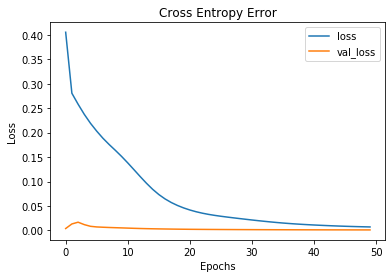

In [413]:
# 可視化
plt.plot(nnc2.loss,label='loss')
plt.plot(nnc2.loss_val,label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cross Entropy Error')
plt.legend()
plt.show()